In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [15]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text, inspect

In [16]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [17]:
# INSPECT

# Create the inspector and connect it to the engine
inspector_gadget = inspect(engine)

# Collect the names of tables within the database
tables = inspector_gadget.get_table_names()

# print metadata for each table
for table in tables:
    print(table)
    print("-----------")
    
    # get columns
    columns = inspector_gadget.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])

    print()

measurement
-----------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station
-----------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT



In [18]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

# View all of the classes that automap found
Base.classes.keys()

/var/folders/m0/r4_vfmn96hzdfnwx72xx60sm0000gn/T/ipykernel_60030/3406670466.py:5: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


['station', 'measurement']

In [19]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [20]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [26]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar() # stackoverflow and chatgpt were used to get .scalar()

most_recent_date

'2017-08-23'

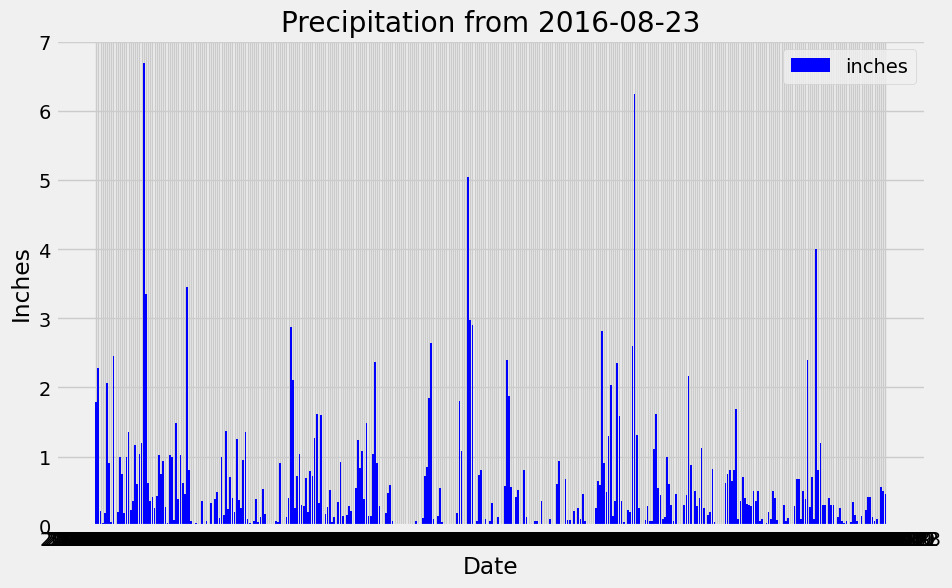

In [48]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

# '2016-08-23' is one year from the last date in the data set


# Perform a query to retrieve the data and precipitation scores
precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= '2016-08-23').all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'inches'])


# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date')


# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(precipitation_df['date'], precipitation_df['inches'], color='b', label='inches')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Precipitation from 2016-08-23')
plt.legend()
plt.show()

In [34]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()


,inches
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [35]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(func.count(Station.station)).scalar()
station_count

9

In [42]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = session.query(Measurement.station, func.count(Measurement.id)).\
                              group_by(Measurement.station).\
                              order_by(func.count(Measurement.id).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [43]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = most_active_stations[0][0]

lowest_temp = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).scalar()

highest_temp = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).scalar()

avg_temp = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).scalar()

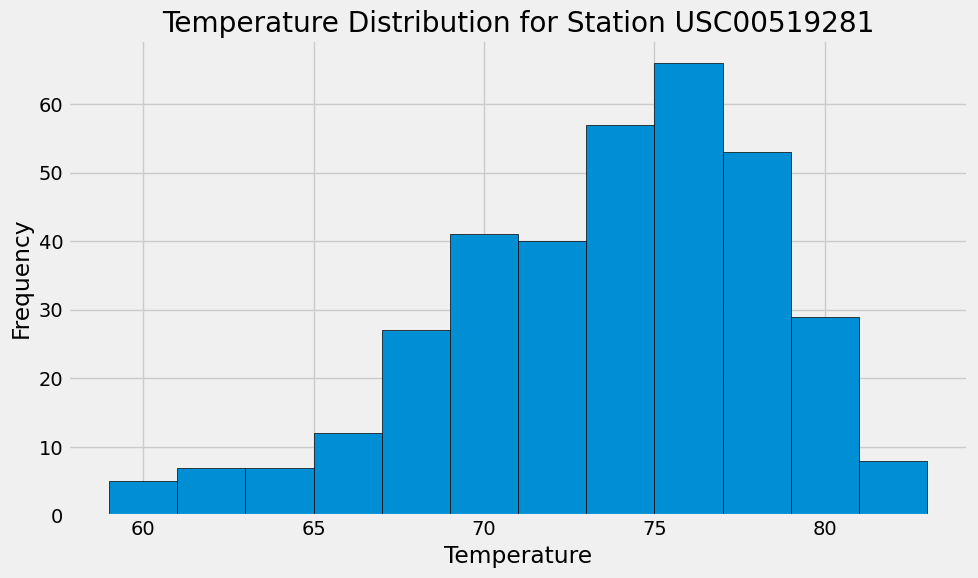

In [44]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= '2016-08-23').all()

temp_df = pd.DataFrame(temp_data, columns=['temperature'])

plt.figure(figsize=(10,6))
plt.hist(temp_df['temperature'], bins=12, edgecolor='black')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title(f'Temperature Distribution for Station {most_active_station}')
plt.tight_layout()
plt.show()

# Close Session

In [49]:
# Close Session
session.close()